# 01. Data Sources & Preprocessing for Marketing Mix Modeling

This notebook explains the different data sources used in Unified Marketing Measurement (UMM) and how to clean and preprocess them before statistical analysis.

## Table of Contents
1. [Overview of Data Sources](#1-overview-of-data-sources)
2. [Media Spend Data](#2-media-spend-data)
3. [Outcome/Response Data](#3-outcomeresponse-data)
4. [Control Variables](#4-control-variables)
5. [Incrementality Test Data](#5-incrementality-test-data)
6. [Attribution Data](#6-attribution-data)
7. [Data Cleaning & Validation](#7-data-cleaning--validation)
8. [Feature Engineering](#8-feature-engineering)

---

## 1. Overview of Data Sources

A complete Unified Marketing Measurement system requires multiple data sources:

| Data Source | Purpose | Typical Granularity | Update Frequency |
|-------------|---------|---------------------|------------------|
| **Media Spend** | Independent variables (X) | Daily/Weekly | Daily |
| **Outcomes** | Dependent variable (Y) | Daily/Weekly | Daily |
| **Controls** | Confounding factors | Daily/Weekly | As available |
| **Incrementality Tests** | Ground truth calibration | Per experiment | Quarterly |
| **Attribution Data** | Touchpoint-level signals | Daily | Daily |

### Data Flow Architecture

```
┌─────────────────────────────────────────────────────────────┐
│                     RAW DATA SOURCES                        │
├─────────────┬─────────────┬──────────────┬─────────────────┤
│ Ad Platforms│ CRM/Sales   │ External APIs│ Experiment Logs │
│ (Google,    │ (Revenue,   │ (Weather,    │ (Geo/Conv lift) │
│  Meta, etc) │ Conversions)│  Holidays)   │                 │
└──────┬──────┴──────┬──────┴──────┬───────┴────────┬────────┘
       │             │             │                │
       ▼             ▼             ▼                ▼
┌─────────────────────────────────────────────────────────────┐
│                   INGESTION & VALIDATION                    │
│  • Schema validation (Pandera)                              │
│  • Missing value handling                                   │
│  • Outlier detection                                        │
│  • Time alignment                                           │
└──────────────────────────┬──────────────────────────────────┘
                           │
                           ▼
┌─────────────────────────────────────────────────────────────┐
│                   TRANSFORMATION                            │
│  • Adstock (carryover effects)                              │
│  • Saturation (diminishing returns)                         │
│  • Seasonality encoding                                     │
│  • Feature scaling                                          │
└─────────────────────────────────────────────────────────────┘
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sys
sys.path.insert(0, '../src')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# For reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Media Spend Data

Media spend data captures your marketing investments across channels. This is typically the **independent variable (X)** in your MMM.

### Common Data Sources

| Source | Channels | API Available | Typical Fields |
|--------|----------|---------------|----------------|
| Google Ads | Search, Display, YouTube | Yes | spend, impressions, clicks, conversions |
| Meta Ads | Facebook, Instagram | Yes | spend, impressions, reach, clicks |
| TV/Linear | Broadcast, Cable | Via vendors | GRPs, spend, impressions |
| Programmatic | Display, Video | Yes (DSP) | spend, impressions, viewable impressions |
| OOH | Billboards, Transit | Manual/Vendor | spend, estimated impressions |
| Audio | Radio, Podcasts, Streaming | Varies | spend, impressions, listens |

### Required Schema

```python
# Required columns
date: datetime        # Date of spend (required)
channel: string       # Channel identifier (required)
spend: float          # Spend amount in local currency (required)

# Optional but recommended
impressions: int      # Number of impressions
clicks: int           # Number of clicks
reach: int            # Unique users reached
```

In [2]:
# Generate synthetic media spend data
# In practice, this comes from ad platform APIs or data warehouses

def generate_media_spend_data(n_days=365):
    """
    Generate synthetic media spend data mimicking real-world patterns.
    
    Real data would come from:
    - Google Ads API: googleads.googleapis.com
    - Meta Marketing API: graph.facebook.com
    - Data warehouse (BigQuery, Snowflake, etc.)
    """
    dates = pd.date_range(end=datetime.now(), periods=n_days, freq='D')
    
    channels = {
        'google_search': {'base': 5000, 'seasonality': 0.2, 'trend': 0.05},
        'google_display': {'base': 2000, 'seasonality': 0.15, 'trend': 0.02},
        'meta_facebook': {'base': 4000, 'seasonality': 0.25, 'trend': 0.03},
        'meta_instagram': {'base': 3000, 'seasonality': 0.30, 'trend': 0.08},
        'tv_linear': {'base': 10000, 'seasonality': 0.4, 'trend': -0.02},
        'programmatic': {'base': 2500, 'seasonality': 0.1, 'trend': 0.10},
    }
    
    records = []
    for date in dates:
        day_of_year = date.dayofyear
        days_elapsed = (date - dates[0]).days
        
        for channel, params in channels.items():
            # Base spend with seasonality and trend
            seasonality = 1 + params['seasonality'] * np.sin(2 * np.pi * day_of_year / 365)
            trend = 1 + params['trend'] * (days_elapsed / 365)
            
            # Weekly pattern (less spend on weekends for some channels)
            weekend_factor = 0.7 if date.dayofweek >= 5 and 'tv' not in channel else 1.0
            
            # Random noise
            noise = np.random.lognormal(0, 0.15)
            
            spend = params['base'] * seasonality * trend * weekend_factor * noise
            
            # Generate correlated metrics
            cpm = np.random.uniform(3, 15)
            impressions = (spend / cpm) * 1000
            ctr = np.random.uniform(0.005, 0.03)
            clicks = impressions * ctr
            
            records.append({
                'date': date,
                'channel': channel,
                'spend': round(spend, 2),
                'impressions': int(impressions),
                'clicks': int(clicks),
            })
    
    return pd.DataFrame(records)

# Generate data
media_spend_df = generate_media_spend_data(365)
print(f"Generated {len(media_spend_df)} rows of media spend data")
print(f"\nChannels: {list(media_spend_df['channel'].unique())}")
print(f"\nDate range: {media_spend_df['date'].min().date()} to {media_spend_df['date'].max().date()}")
print(f"\nTotal Spend: ${media_spend_df['spend'].sum():,.0f}")
media_spend_df.head(10)

Generated 2190 rows of media spend data

Channels: ['google_search', 'google_display', 'meta_facebook', 'meta_instagram', 'tv_linear', 'programmatic']

Date range: 2025-02-04 to 2026-02-03

Total Spend: $9,371,085


,date,channel,spend,impressions,clicks
0,2025-02-04 16:35:37.271656,google_search,5997.30,508939,10161
1,2025-02-04 16:35:37.271656,google_display,2125.47,436242,3882
2,2025-02-04 16:35:37.271656,meta_facebook,5787.34,1782358,52129
3,2025-02-04 16:35:37.271656,meta_instagram,3938.26,303192,3125
4,2025-02-04 16:35:37.271656,tv_linear,11443.07,1720527,31174
5,2025-02-04 16:35:37.271656,programmatic,2463.43,301029,3696
6,2025-02-05 16:35:37.271656,google_search,4794.86,737020,10435
7,2025-02-05 16:35:37.271656,google_display,2279.31,269013,6625
8,2025-02-05 16:35:37.271656,meta_facebook,4627.82,457792,2820
9,2025-02-05 16:35:37.271656,meta_instagram,2845.50,276516,2561


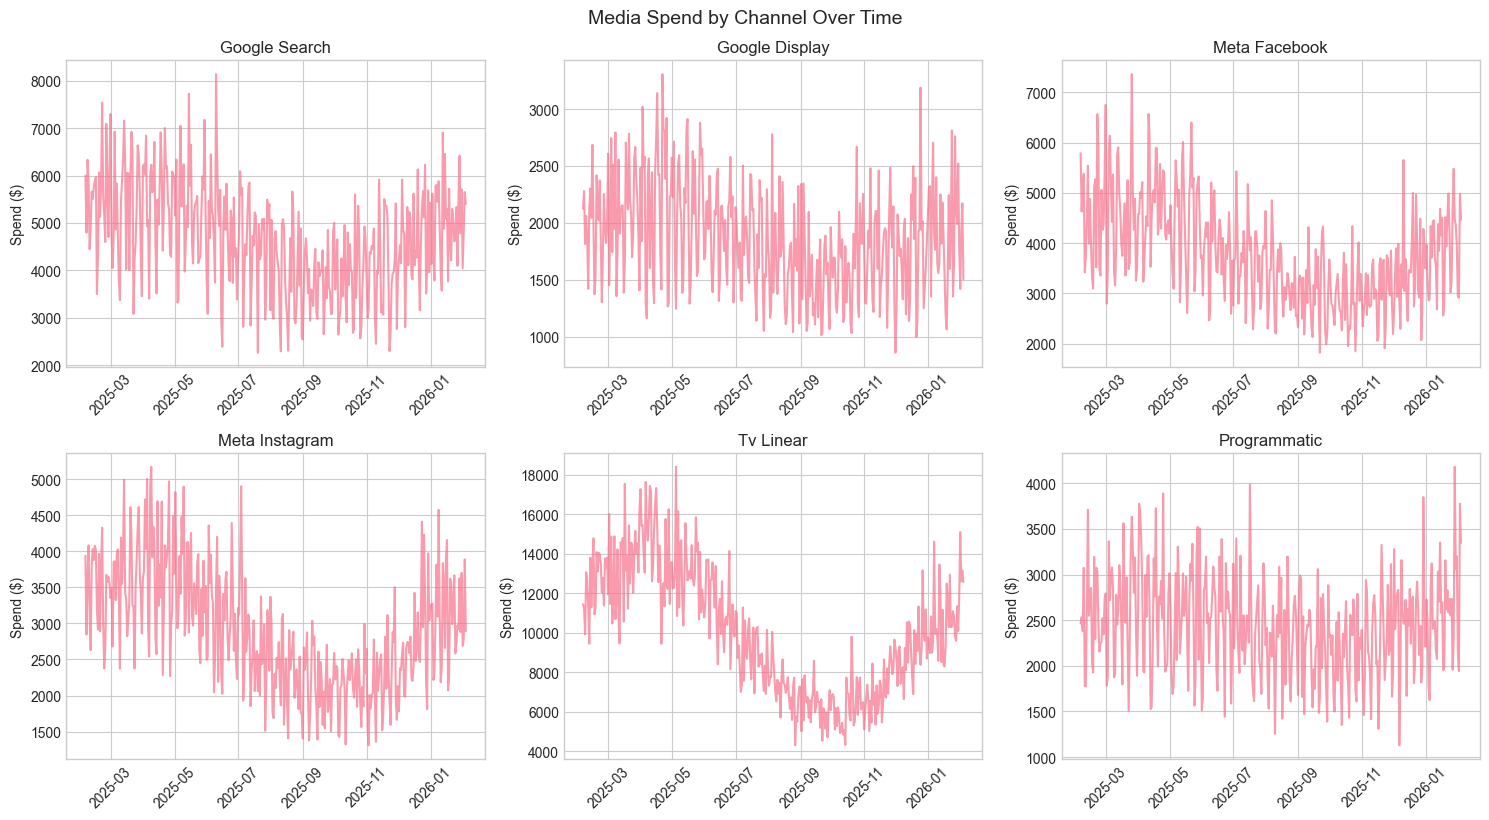

In [4]:
# Visualize media spend by channel
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, channel in enumerate(media_spend_df['channel'].unique()):
    channel_data = media_spend_df[media_spend_df['channel'] == channel]
    axes[idx].plot(channel_data['date'], channel_data['spend'], alpha=0.7)
    axes[idx].set_title(channel.replace('_', ' ').title())
    axes[idx].set_ylabel('Spend ($)')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Media Spend by Channel Over Time', y=1.02, fontsize=14)
plt.show()

# 01: Data Sources & Preprocessing for Marketing Mix Modeling

This notebook explains the different data sources used in Unified Marketing Measurement and how to clean, validate, and prepare them for statistical analysis.

## Learning Objectives
1. Understand the 5 key data sources for MMM
2. Learn data validation techniques using schemas
3. Master preprocessing pipelines for each data type
4. Apply best practices for data quality assurance

---

## Overview of Data Sources

Unified-M uses **5 key data sources** that feed into the measurement system:

| # | Data Source | Required | Description |
|---|-------------|----------|-------------|
| 1 | **Media Spend** | Yes | Daily spend, impressions, clicks per channel |
| 2 | **Outcomes** | Yes | Revenue, conversions, leads |
| 3 | **Control Variables** | Optional | Holidays, promotions, economic indicators |
| 4 | **Incrementality Tests** | Optional | Geo tests, conversion lift studies |
| 5 | **Attribution Data** | Optional | MTA paths, last-click data |

In [ ]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 1. Generate Synthetic Data for Learning

Let's create realistic synthetic data to understand each data type.

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Define time range: 2 years of daily data
n_days = 730
dates = pd.date_range(end=datetime.now(), periods=n_days, freq='D')

print(f"Data range: {dates[0].date()} to {dates[-1].date()}")
print(f"Total days: {len(dates)}")

📅 Data range: 2024-02-05 to 2026-02-03
📊 Total days: 730


### 1.1 Media Spend Data

Media spend data captures how much you're investing in each marketing channel over time.

**Schema Requirements:**
- `date`: Daily granularity (timestamp)
- `channel`: Channel identifier (string)  
- `spend`: Daily spend in currency (float, >= 0)
- `impressions`: Number of impressions (int, >= 0) - optional
- `clicks`: Number of clicks (int, >= 0) - optional

In [ ]:
def generate_media_spend(dates, channels, base_spends):
    """
    Generate realistic media spend data with:
    - Seasonality (higher spend in Q4)
    - Weekly patterns (lower on weekends)
    - Random noise
    """
    records = []
    
    for date in dates:
        for channel, base_spend in zip(channels, base_spends):
            # Seasonality: 30% higher in Q4 (holiday season)
            q4_multiplier = 1.3 if date.quarter == 4 else 1.0
            
            # Weekly pattern: 20% lower on weekends
            weekend_multiplier = 0.8 if date.dayofweek >= 5 else 1.0
            
            # Calculate spend with noise
            spend = base_spend * q4_multiplier * weekend_multiplier
            spend *= np.random.uniform(0.8, 1.2)  # ±20% noise
            spend = max(0, spend)
            
            # Calculate impressions (CPM varies by channel)
            cpm = {'google': 5, 'meta': 8, 'tv': 15, 'display': 3}[channel]
            impressions = int(spend / cpm * 1000 * np.random.uniform(0.9, 1.1))
            
            # Calculate clicks (CTR varies by channel)
            ctr = {'google': 0.03, 'meta': 0.02, 'tv': 0, 'display': 0.005}[channel]
            clicks = int(impressions * ctr * np.random.uniform(0.8, 1.2))
            
            records.append({
                'date': date,
                'channel': channel,
                'spend': round(spend, 2),
                'impressions': impressions,
                'clicks': clicks
            })
    
    return pd.DataFrame(records)

# Generate media spend
channels = ['google', 'meta', 'tv', 'display']
base_spends = [2000, 1500, 3000, 800]  # Daily base spend per channel

media_spend = generate_media_spend(dates, channels, base_spends)

print("Media Spend Data Sample:")
display(media_spend.head(10))

print("\nMedia Spend Summary:")
display(media_spend.groupby('channel').agg({
    'spend': ['sum', 'mean', 'std'],
    'impressions': 'sum',
    'clicks': 'sum'
}).round(2))

📊 Media Spend Data Sample:


,date,channel,spend,impressions,clicks
0,2024-02-05 16:36:47.129889,google,"1,899.63",414174,13578
1,2024-02-05 16:36:47.129889,meta,"1,559.20",181491,3130
2,2024-02-05 16:36:47.129889,tv,"2,469.70",176704,0
3,2024-02-05 16:36:47.129889,display,866.58,261164,1551
4,2024-02-06 16:36:47.129889,google,"2,265.95",427117,11182
5,2024-02-06 16:36:47.129889,meta,"1,310.04",157344,3178
6,2024-02-06 16:36:47.129889,tv,"2,918.33",186432,0
7,2024-02-06 16:36:47.129889,display,684.64,218725,1035
8,2024-02-07 16:36:47.129889,google,"1,964.86",415384,10964
9,2024-02-07 16:36:47.129889,meta,"1,508.54",192052,3144



📈 Media Spend Summary:


spend                 impressions   clicks
                 sum     mean    std         sum      sum
channel                                                  
display   593,555.03   813.09 157.93   197655065   990719
google  1,486,366.90 2,036.12 394.04   296740054  8773142
meta    1,111,680.87 1,522.85 294.02   138750024  2757394
tv      2,221,739.41 3,043.48 582.34   147416361        0

In [ ]:
def generate_outcomes(dates, media_spend):
    """Generate realistic outcome data influenced by media spend."""
    # Aggregate spend by date
    daily_spend = media_spend.pivot_table(
        index='date', columns='channel', values='spend', aggfunc='sum'
    ).fillna(0)
    
    records = []
    
    # Channel effectiveness (true coefficients)
    channel_effects = {'google': 3.5, 'meta': 2.8, 'tv': 1.5, 'display': 1.2}
    
    for i, date in enumerate(dates):
        # Baseline revenue (organic)
        baseline = 50000
        
        # Seasonal pattern (30% higher in Q4)
        if date.quarter == 4:
            baseline *= 1.3
        
        # Media contribution with lag (sum of last 7 days with decay)
        media_contribution = 0
        for channel, effect in channel_effects.items():
            lagged_spend = 0
            for lag in range(min(7, i+1)):
                if i - lag >= 0:
                    decay = 0.7 ** lag  # Geometric decay
                    spend_val = daily_spend.iloc[i - lag][channel]
                    # Apply saturation (Hill function)
                    K = 3000  # Half-saturation point
                    saturated = spend_val / (K + spend_val)
                    lagged_spend += saturated * decay
            
            media_contribution += effect * lagged_spend * 10000
        
        # Total revenue with noise
        revenue = (baseline + media_contribution) * np.random.uniform(0.9, 1.1)
        conversions = int(revenue / np.random.uniform(80, 120))  # AOV
        
        records.append({
            'date': date,
            'revenue': round(revenue, 2),
            'conversions': conversions
        })
    
    return pd.DataFrame(records)

# Generate outcomes
outcomes = generate_outcomes(dates, media_spend)

print("Outcomes Data Sample:")
display(outcomes.head(10))

print("\nOutcomes Summary:")
display(outcomes.describe())

📊 Outcomes Data Sample:


,date,revenue,conversions
0,2024-02-05 16:36:47.129889,"74,671.04",698
1,2024-02-06 16:36:47.129889,"106,513.95",918
2,2024-02-07 16:36:47.129889,"114,711.76",1022
3,2024-02-08 16:36:47.129889,"140,729.49",1653
4,2024-02-09 16:36:47.129889,"139,262.94",1604
5,2024-02-10 16:36:47.129889,"135,529.00",1497
6,2024-02-11 16:36:47.129889,"144,010.10",1493
7,2024-02-12 16:36:47.129889,"157,409.48",1850
8,2024-02-13 16:36:47.129889,"159,075.61",1782
9,2024-02-14 16:36:47.129889,"153,334.25",1638



📈 Outcomes Summary:


,date,revenue,conversions
count,730,730.00,730.00
mean,2025-02-04 04:36:47.129889024,"155,626.18","1,581.03"
min,2024-02-05 16:36:47.129889,"74,671.04",698.00
25%,2024-08-05 22:36:47.129889024,"143,573.36","1,392.00"
50%,2025-02-04 04:36:47.129889024,"151,802.65","1,552.50"
75%,2025-08-05 10:36:47.129889024,"163,343.08","1,738.25"
max,2026-02-03 16:36:47.129889,"200,070.13","2,415.00"
std,NaN,"17,015.82",254.09


In [ ]:
def generate_controls(dates):
    """Generate control variables."""
    records = []
    holidays = [(1, 1), (7, 4), (11, 28), (12, 25)]  # Major US holidays
    
    for date in dates:
        is_holiday = any(date.month == m and abs(date.day - d) <= 1 for m, d in holidays)
        promo_prob = 0.15 if date.quarter == 4 else 0.05
        promo = np.random.random() < promo_prob
        
        # Macro index (random walk)
        if len(records) == 0:
            macro_index = 100
        else:
            macro_index = records[-1]['macro_index'] + np.random.normal(0.01, 0.5)
        macro_index = max(80, min(120, macro_index))
        
        records.append({
            'date': date,
            'is_holiday': int(is_holiday),
            'is_weekend': int(date.dayofweek >= 5),
            'promo': int(promo),
            'macro_index': round(macro_index, 2)
        })
    
    return pd.DataFrame(records)

controls = generate_controls(dates)
print("Control Variables Sample:")
display(controls.head(10))

📊 Control Variables Sample:


,date,is_holiday,is_weekend,promo,macro_index
0,2024-02-05 16:36:47.129889,0,0,0,100.00
1,2024-02-06 16:36:47.129889,0,0,0,100.03
2,2024-02-07 16:36:47.129889,0,0,0,99.86
3,2024-02-08 16:36:47.129889,0,0,0,99.56
4,2024-02-09 16:36:47.129889,0,0,0,99.17
5,2024-02-10 16:36:47.129889,0,1,0,99.14
6,2024-02-11 16:36:47.129889,0,1,0,99.72
7,2024-02-12 16:36:47.129889,0,0,0,99.38
8,2024-02-13 16:36:47.129889,0,0,0,99.96
9,2024-02-14 16:36:47.129889,0,0,0,99.24


### 1.4 Incrementality Test Data

Incrementality tests measure the **causal impact** of marketing through controlled experiments.

**Test Types:**
- **Geo Tests**: Compare treatment vs control regions
- **Conversion Lift**: Platform's built-in lift tests
- **Holdout Tests**: Suppress ads for control group

In [ ]:
def generate_incrementality_tests(channels, date_range):
    """Generate synthetic incrementality test results."""
    tests = []
    test_id = 1
    true_lifts = {'google': 3.2, 'meta': 2.5, 'tv': 1.8, 'display': 1.0}
    
    for channel in channels:
        for _ in range(np.random.randint(2, 5)):  # 2-4 tests per channel
            test_duration = np.random.randint(14, 29)
            start_idx = np.random.randint(0, len(date_range) - test_duration - 30)
            start_date = date_range[start_idx]
            end_date = start_date + timedelta(days=test_duration)
            
            lift = true_lifts[channel] + np.random.normal(0, 0.3)
            ci_width = np.random.uniform(0.3, 0.8)
            
            tests.append({
                'test_id': f'TEST_{test_id:03d}',
                'channel': channel,
                'start_date': start_date,
                'end_date': end_date,
                'test_type': np.random.choice(['geo_test', 'conversion_lift', 'holdout']),
                'lift_estimate': round(lift, 3),
                'lift_ci_lower': round(lift - ci_width, 3),
                'lift_ci_upper': round(lift + ci_width, 3),
                'p_value': round(np.random.uniform(0.001, 0.1), 4)
            })
            test_id += 1
    
    return pd.DataFrame(tests)

incrementality_tests = generate_incrementality_tests(channels, dates)
print("Incrementality Test Results:")
display(incrementality_tests)

📊 Incrementality Test Results:


,test_id,channel,start_date,end_date,test_type,lift_estimate,lift_ci_lower,lift_ci_upper,p_value
0,TEST_001,google,2025-05-12 16:36:47.129889,2025-06-02 16:36:47.129889,geo_test,3.57,3.04,4.09,0.05
1,TEST_002,google,2024-07-02 16:36:47.129889,2024-07-16 16:36:47.129889,holdout,3.09,2.34,3.83,0.01
2,TEST_003,meta,2025-11-02 16:36:47.129889,2025-11-25 16:36:47.129889,holdout,2.45,1.94,2.96,0.10
3,TEST_004,meta,2025-09-14 16:36:47.129889,2025-09-30 16:36:47.129889,conversion_lift,2.23,1.88,2.58,0.09
4,TEST_005,meta,2024-04-19 16:36:47.129889,2024-05-07 16:36:47.129889,conversion_lift,2.73,2.32,3.13,0.09
5,TEST_006,meta,2024-08-09 16:36:47.129889,2024-09-03 16:36:47.129889,holdout,2.69,1.98,3.40,0.03
6,TEST_007,tv,2024-09-13 16:36:47.129889,2024-09-30 16:36:47.129889,conversion_lift,1.66,1.21,2.10,0.05
7,TEST_008,tv,2025-04-19 16:36:47.129889,2025-05-16 16:36:47.129889,geo_test,1.88,1.32,2.44,0.06
8,TEST_009,tv,2025-03-18 16:36:47.129889,2025-04-08 16:36:47.129889,conversion_lift,2.12,1.74,2.50,0.04
9,TEST_010,display,2024-05-04 16:36:47.129889,2024-05-21 16:36:47.129889,conversion_lift,0.75,0.20,1.29,0.03


---
## 2. Data Validation

Before analysis, data must be validated against schemas and business rules.

In [ ]:
class DataValidator:
    """Validates marketing data against schemas and business rules."""
    
    def __init__(self):
        self.errors = []
        self.warnings = []
    
    def validate_media_spend(self, df):
        """Validate media spend data."""
        self.errors, self.warnings = [], []
        
        # Required columns
        required = ['date', 'channel', 'spend']
        missing = [c for c in required if c not in df.columns]
        if missing:
            self.errors.append(f"Missing required columns: {missing}")
            return False
        
        # Value checks
        if (df['spend'] < 0).any():
            self.errors.append("Negative spend values found")
        
        # Duplicate checks
        duplicates = df.duplicated(subset=['date', 'channel']).sum()
        if duplicates > 0:
            self.errors.append(f"{duplicates} duplicate date-channel combinations")
        
        return len(self.errors) == 0
    
    def validate_outcomes(self, df):
        """Validate outcomes data."""
        self.errors, self.warnings = [], []
        
        if 'date' not in df.columns:
            self.errors.append("Missing 'date' column")
        
        if 'revenue' not in df.columns and 'conversions' not in df.columns:
            self.errors.append("Must have 'revenue' or 'conversions'")
        
        if 'revenue' in df.columns and (df['revenue'] < 0).any():
            self.errors.append("Negative revenue values")
        
        return len(self.errors) == 0
    
    def report(self):
        """Print validation report."""
        print("=" * 50)
        if self.errors:
            print("ERRORS:")
            for e in self.errors:
                print(f"   - {e}")
        else:
            print("No errors found")
        if self.warnings:
            print("WARNINGS:")
            for w in self.warnings:
                print(f"   - {w}")
        print("=" * 50)

# Validate data
validator = DataValidator()
print("Validating Media Spend...")
validator.validate_media_spend(media_spend)
validator.report()

print("\nValidating Outcomes...")
validator.validate_outcomes(outcomes)
validator.report()

Validating Media Spend...
✅ No errors found

Validating Outcomes...
✅ No errors found


In [ ]:
def preprocess_for_mmm(media_spend, outcomes, controls=None):
    """
    Preprocess data for MMM training.
    
    Steps:
    1. Pivot media spend from long to wide format
    2. Merge all data sources on date
    3. Handle missing values
    4. Create target variable
    """
    print("Step 1: Pivoting media spend to wide format...")
    media_wide = media_spend.pivot_table(
        index='date', columns='channel', values='spend', aggfunc='sum'
    ).reset_index()
    media_wide.columns = ['date'] + [f"{c}_spend" for c in media_wide.columns[1:]]
    
    print("Step 2: Merging with outcomes...")
    mmm_data = media_wide.merge(outcomes, on='date', how='inner')
    
    if controls is not None:
        print("Step 3: Merging with controls...")
        mmm_data = mmm_data.merge(controls, on='date', how='left')
    
    print("Step 4: Handling missing values...")
    spend_cols = [c for c in mmm_data.columns if c.endswith('_spend')]
    mmm_data[spend_cols] = mmm_data[spend_cols].fillna(0)
    
    print("Step 5: Creating target variable 'y'...")
    mmm_data['y'] = mmm_data['revenue']
    mmm_data = mmm_data.sort_values('date').reset_index(drop=True)
    
    print(f"\nPreprocessing complete!")
    print(f"   Shape: {mmm_data.shape}")
    print(f"   Columns: {list(mmm_data.columns)}")
    
    return mmm_data

mmm_data = preprocess_for_mmm(media_spend, outcomes, controls)
display(mmm_data.head())

Step 1: Pivoting media spend to wide format...
Step 2: Merging with outcomes...
Step 3: Merging with controls...
Step 4: Handling missing values...
Step 5: Creating target variable 'y'...

✅ Preprocessing complete!
   Shape: (730, 12)
   Columns: ['date', 'display_spend', 'google_spend', 'meta_spend', 'tv_spend', 'revenue', 'conversions', 'is_holiday', 'is_weekend', 'promo', 'macro_index', 'y']


,date,display_spend,google_spend,meta_spend,tv_spend,revenue,conversions,is_holiday,is_weekend,promo,macro_index,y
0,2024-02-05 16:36:47.129889,866.58,"1,899.63","1,559.20","2,469.70","74,671.04",698,0,0,0,100.00,"74,671.04"
1,2024-02-06 16:36:47.129889,684.64,"2,265.95","1,310.04","2,918.33","106,513.95",918,0,0,0,100.03,"106,513.95"
2,2024-02-07 16:36:47.129889,943.64,"1,964.86","1,508.54","3,129.05","114,711.76",1022,0,0,0,99.86,"114,711.76"
3,2024-02-08 16:36:47.129889,852.01,"1,843.69","1,464.09","2,441.27","140,729.49",1653,0,0,0,99.56,"140,729.49"
4,2024-02-09 16:36:47.129889,702.71,"2,037.37","1,665.08","3,117.48","139,262.94",1604,0,0,0,99.17,"139,262.94"


---
## 4. Save Processed Data

In [ ]:
# Save to parquet
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

media_spend.to_parquet(output_dir / 'media_spend.parquet', index=False)
outcomes.to_parquet(output_dir / 'outcomes.parquet', index=False)
controls.to_parquet(output_dir / 'controls.parquet', index=False)
incrementality_tests.to_parquet(output_dir / 'incrementality_tests.parquet', index=False)
mmm_data.to_parquet(output_dir / 'mmm_input.parquet', index=False)

print("Data saved to:")
for f in output_dir.glob('*.parquet'):
    print(f"   - {f.name}")

✅ Data saved to:
   - media_spend.parquet
   - mmm_input.parquet
   - outcomes.parquet
   - controls.parquet
   - incrementality_tests.parquet
